# Final Project: Higgs Boson Search in the 4-Lepton Channel
**Physics 129, Fall 2025**

Name: Soumay Garg

Partner Name: Michael Speights

---

## 1. Introduction & Background

### 1.1 Discovery Papers Confirmation
We have read and reviewed the following landmark discovery papers:
- **ATLAS Collaboration**, "Observation of a new particle in the search for the Standard Model Higgs boson with the ATLAS detector at the LHC," *Physics Letters B* **716** (2012) 1-29
- **CMS Collaboration**, "Observation of a new boson at a mass of 125 GeV with the CMS experiment at the LHC," *Physics Letters B* **716** (2012) 30-61
- **ATLAS Collaboration**, "A Particle Consistent with the Higgs Boson Observed with the ATLAS Detector at the Large Hadron Collider," *Science* **338** (2012) 1576-1582
- **CMS Collaboration**, "A New Boson with a Mass of 125 GeV Observed with the CMS Experiment at the Large Hadron Collider," *Science* **338** (2012) 1569-1575

### 1.2 Physics Motivation
The Higgs boson is the quantum excitation of the Higgs field, which gives mass to fundamental particles through the Brout-Englert-Higgs mechanism. The $H \rightarrow ZZ^* \rightarrow 4\ell$ channel (where $\ell = e, \mu$) is known as the "golden channel" because:
- It has a clean experimental signature (4 isolated leptons)
- Excellent mass resolution (~1-2 GeV)
- Low background contamination
- Fully reconstructable final state

### 1.3 Overview
This notebook implements a search for the Higgs boson decay $H \rightarrow ZZ^* \rightarrow 4\ell$ using ATLAS Open Data.

**Objectives:**
1. Identify events with four leptons (electrons or muons)
2. Select candidate events using trigger, identification, and kinematic cuts
3. Compare data with Monte Carlo (MC) simulations for Signal ($m_H=125$ GeV) and Background ($ZZ^*$)
4. Calculate the invariant mass of the four-lepton system ($m_{4\ell}$)
5. Estimate the expected sensitivity and observed significance

---

## 2. Dataset and Simulated Samples

### 2.1 Data
| Sample | Description | Integrated Luminosity |
|--------|-------------|----------------------|
| `data_A-D.4lep.root` | ATLAS 13 TeV collision data | $\mathcal{L} = 10\ \text{fb}^{-1}$ |

### 2.2 Monte Carlo Simulations
All MC samples are normalized to $10\ \text{fb}^{-1}$ using the formula:
$$w = \frac{\mathcal{L} \cdot \sigma \cdot w_{MC} \cdot \text{SF}}{\sum w_{gen}}$$

| Process | Cross Section | Description |
|---------|---------------|-------------|
| **Signal** |||
| ggF H(125) | ~44 fb | Gluon-gluon fusion (dominant) |
| VBF H(125) | ~3.8 fb | Vector boson fusion |
| WH(125) | ~1.4 fb | Associated W production |
| ZH(125) | ~0.9 fb | Associated Z production |
| **Background** |||
| $ZZ^* \rightarrow 4\ell$ | ~1.3 pb | Irreducible continuum background |

### 2.3 Center of Mass Energy
$\sqrt{s} = 13$ TeV (LHC Run 2)

In [67]:
import uproot
import awkward as ak
import vector
import numpy as np
import matplotlib.pyplot as plt

# Register vector behavior
vector.register_awkward()

# CONFIGURATION
LUMI = 10.0 # fb^-1
base_path = r"C:\Users\souma\Downloads"

# Cross Section Overrides (pb)
# Note: Raw file values might be incorrect for these samples
XSEC_OVERRIDES = {
    'ZH': 0.00012,
    'WH': 0.00015
}

samples = {
    'data': {
        'files': [f'{base_path}\\data_A.4lep.root', f'{base_path}\\data_B.4lep.root',
                  f'{base_path}\\data_C.4lep.root', f'{base_path}\\data_D.4lep.root'],
        'type': 'data', 'label': 'Data'
    },
    'background': {
        'files': [f'{base_path}\\mc_363490.llll.4lep.root'],
        'type': 'mc', 'label': r'ZZ $\rightarrow 4\ell$', 'color': 'royalblue'
    },
    # Signals
    'signal_ggF': {
        'files': [f'{base_path}\\mc_345060.ggH125_ZZ4lep.4lep.root'],
        'type': 'mc', 'label': 'ggF H(125)', 'color': 'red'
    },
    'signal_VBF': {
        'files': [f'{base_path}\\mc_344235.VBFH125_ZZ4lep.4lep.root'],
        'type': 'mc', 'label': 'VBF H(125)', 'color': 'salmon' 
    },
    'signal_ZH': {
        'files': [f'{base_path}\\mc_341947.ZH125_ZZ4lep.4lep.root'],
        'type': 'mc', 'label': 'ZH(125)', 'color': 'orange'
    },
    'signal_WH': {
        'files': [f'{base_path}\\mc_341964.WH125_ZZ4lep.4lep.root'],
        'type': 'mc', 'label': 'WH(125)', 'color': 'coral' 
    }
}

branches = [
    'lep_pt', 'lep_eta', 'lep_phi', 'lep_E', 'lep_charge', 'lep_type', 
    'lep_isTightID', 'lep_ptcone30', 'lep_etcone20', 'lep_n',
    'lep_tracksigd0pvunbiased', 'lep_z0', 
    'trigE', 'trigM', 'scaleFactor_PILEUP', 'scaleFactor_ELE', 
    'scaleFactor_MUON', 'scaleFactor_LepTRIGGER', 
    'mcWeight', 'XSection', 'SumWeights', 'runNumber', 'eventNumber'
]

print("Configuration updated.")

Configuration updated.


## 3. Helper Functions

We need two utility functions to streamline the analysis:

1.  **`get_data(files, branches)`**: This function opens the ROOT files using `uproot` and concatenates them into a single `awkward` array. It handles cases where multiple files (like `data_A`, `data_B`, etc.) need to be combined into one dataset.
2.  **`calculate_weight(events, luminosity)`**: This normalizes the Monte Carlo (MC) simulations to match the real data.
    * The formula used is:
        $$W = \frac{L \cdot \sigma \cdot w_{MC} \cdot \text{SFs}}{\sum w_{initial}}$$
    * Where $L$ is luminosity ($10 \text{ fb}^{-1}$), $\sigma$ is cross-section, and SFs are the scale factors for detector efficiency (pileup, electrons, muons, triggers)[cite: 341, 350].

In [68]:
def get_data(files, branches):
    """Lazily reads data from a list of files."""
    data_arrays = []
    for file in files:
        try:
            with uproot.open(f"{file}:mini") as tree:
                data_arrays.append(tree.arrays(branches, library="ak"))
        except FileNotFoundError:
            print(f"Warning: File {file} not found. Skipping.")
    return ak.concatenate(data_arrays) if data_arrays else None

def calculate_weight(events, luminosity, sample_name=""):
    """
    Calculates event weights using standard formula + XSection overrides.
    """
    # 1. Determine Cross Section
    xsec = events.XSection
    
    # Check for overrides (e.g. ZH or WH) based on sample name
    for key, val in XSEC_OVERRIDES.items():
        if key in sample_name: # e.g. if 'ZH' in 'signal_ZH'
            xsec = val
            
    # 2. Calculate Base Weight (convert xsec pb -> fb using *1000)
    weight = (luminosity * xsec * 1000 * events.mcWeight) / events.SumWeights
    
    # 3. Apply Scale Factors
    weight = weight * events.scaleFactor_PILEUP * \
             events.scaleFactor_ELE * \
             events.scaleFactor_MUON * \
             events.scaleFactor_LepTRIGGER
             
    return weight

print("Helper functions defined.")

Helper functions defined.


## 4. Event Selection and Analysis Loop

We now iterate through our Data, Signal, and Background samples. For each sample, we apply the following selection criteria (cuts) to "rediscover" the Higgs:

1.  **Trigger Selection**: We require the event to have fired either a Single Electron (`trigE`) or Single Muon (`trigM`) trigger.
2.  **Lepton Definition**:
    * **Type**: Electron (ID 11) or Muon (ID 13).
    * **Kinematics**: $p_T > 5$ GeV and $|\eta| < 2.47$.
    * **Quality**: Must pass "Tight" identification (`lep_isTightID`).
    * **Isolation**: The lepton must be isolated from other activity in the detector. We require both track isolation (`ptcone30/pt < 0.15`) and calorimeter isolation (`etcone20/pt < 0.15`).
3.  **Event Topology**:
    * **Four Leptons**: The event must contain at least 4 "good" leptons defined above.
    * **Charge**: The sum of charges of the four leptons must be zero (neutral Higgs).
    * **$p_T$ Thresholds**: To match the discovery analysis, we require the sorted leptons to have $p_T > 20, 15, 10$ GeV respectively.
4.  **Mass Calculation**: We compute the invariant mass ($m_{4\ell}$) of the four-lepton system.

In [69]:
results = {}
cutflow = {}

# Constants
M_Z = 91.2  # Z boson mass in GeV

print("Starting analysis loop")

for sample_name, config in samples.items():
    print(f"Processing {config['label']}...")
    
    # 1. LOAD DATA
    events = get_data(config['files'], branches)
    if events is None: continue
    
    cutflow[sample_name] = {'Initial': len(events)}
    
    # 2. TRIGGER
    trigger_mask = events.trigE | events.trigM
    events = events[trigger_mask]
    cutflow[sample_name]['Trigger'] = len(events)

    # 3. OBJECT SELECTION
    leptons = ak.zip({
        "pt": events.lep_pt,
        "eta": events.lep_eta,
        "phi": events.lep_phi,
        "E": events.lep_E,
        "charge": events.lep_charge,
        "d0sig": events.lep_tracksigd0pvunbiased,
        "z0": events.lep_z0,
        "ptcone30": events.lep_ptcone30,
        "etcone20": events.lep_etcone20
    }, with_name="Momentum4D")

    lep_type = events.lep_type
    
    # Calculate z0 * sin(theta)
    theta = 2 * np.arctan(np.exp(-leptons.eta))
    z0_sin_theta = np.abs(leptons.z0 * np.sin(theta))

    # --- LEPTON CUTS (vectorized) ---
    is_electron = np.abs(lep_type) == 11
    ele_crack_veto = (np.abs(leptons.eta) > 1.37) & (np.abs(leptons.eta) < 1.52)
    ele_cut = is_electron & (leptons.pt > 7000) & (np.abs(leptons.eta) < 2.47) & \
              (np.abs(leptons.d0sig) < 6.5) & (~ele_crack_veto)

    is_muon = np.abs(lep_type) == 13
    muon_cut = is_muon & (leptons.pt > 6000) & (np.abs(leptons.eta) < 2.7) & \
               (np.abs(leptons.d0sig) < 3.5)

    iso_cut = ((leptons.ptcone30 / leptons.pt) < 0.15) & \
              ((leptons.etcone20 / leptons.pt) < 0.20)
    common_cut = (z0_sin_theta < 0.5) & iso_cut

    good_lep_mask = (ele_cut | muon_cut) & common_cut
    events["leptons"] = leptons[good_lep_mask]
    events["lep_type_good"] = lep_type[good_lep_mask]
    
    cutflow[sample_name]['Lepton Object'] = len(events)

    # 4. EVENT SELECTION
    
    # Cut: EXACTLY 4 good leptons
    has_four = ak.num(events.leptons) == 4
    events = events[has_four]
    cutflow[sample_name]['== 4 Leptons'] = len(events)
    
    # Cut: Total Charge == 0
    total_charge = ak.sum(events.leptons.charge, axis=1)
    events = events[total_charge == 0]
    cutflow[sample_name]['Total Charge 0'] = len(events)
    
    # VECTORIZED OSSF Z CANDIDATE FINDING
    # Get the 4 leptons as separate arrays for vectorized ops
    l0 = events.leptons[:, 0]
    l1 = events.leptons[:, 1]
    l2 = events.leptons[:, 2]
    l3 = events.leptons[:, 3]
    
    t0 = events.lep_type_good[:, 0]
    t1 = events.lep_type_good[:, 1]
    t2 = events.lep_type_good[:, 2]
    t3 = events.lep_type_good[:, 3]
    
    c0 = l0.charge
    c1 = l1.charge
    c2 = l2.charge
    c3 = l3.charge
    
    # Calculate all 6 pair masses (in GeV)
    m01 = (l0 + l1).mass / 1000.0
    m02 = (l0 + l2).mass / 1000.0
    m03 = (l0 + l3).mass / 1000.0
    m12 = (l1 + l2).mass / 1000.0
    m13 = (l1 + l3).mass / 1000.0
    m23 = (l2 + l3).mass / 1000.0
    
    # Check OSSF for each pair (same flavor AND opposite sign)
    ossf_01 = (t0 == t1) & (c0 * c1 < 0)
    ossf_02 = (t0 == t2) & (c0 * c2 < 0)
    ossf_03 = (t0 == t3) & (c0 * c3 < 0)
    ossf_12 = (t1 == t2) & (c1 * c2 < 0)
    ossf_13 = (t1 == t3) & (c1 * c3 < 0)
    ossf_23 = (t2 == t3) & (c2 * c3 < 0)
    
    # Three possible non-overlapping pairings: (01,23), (02,13), (03,12)
    # For each pairing, check if BOTH pairs are OSSF
    valid_A = ossf_01 & ossf_23  # pairing (0,1) + (2,3)
    valid_B = ossf_02 & ossf_13  # pairing (0,2) + (1,3)
    valid_C = ossf_03 & ossf_12  # pairing (0,3) + (1,2)
    
    # At least one valid pairing must exist
    has_ossf = valid_A | valid_B | valid_C
    
    # For valid pairings, determine Z1 (closer to M_Z) and Z2
    # Initialize with NaN
    n_evt = len(events)
    mZ1 = np.full(n_evt, np.nan)
    mZ2 = np.full(n_evt, np.nan)
    
    # Convert to numpy for conditional assignment
    m01_np = ak.to_numpy(m01)
    m02_np = ak.to_numpy(m02)
    m03_np = ak.to_numpy(m03)
    m12_np = ak.to_numpy(m12)
    m13_np = ak.to_numpy(m13)
    m23_np = ak.to_numpy(m23)
    
    valid_A_np = ak.to_numpy(valid_A)
    valid_B_np = ak.to_numpy(valid_B)
    valid_C_np = ak.to_numpy(valid_C)
    
    # For each event, find the best pairing (minimize |mZ1 - M_Z|)
    for i in range(n_evt):
        candidates = []
        if valid_A_np[i]:
            ma, mb = m01_np[i], m23_np[i]
            if abs(ma - M_Z) < abs(mb - M_Z):
                candidates.append((ma, mb, abs(ma - M_Z)))
            else:
                candidates.append((mb, ma, abs(mb - M_Z)))
        if valid_B_np[i]:
            ma, mb = m02_np[i], m13_np[i]
            if abs(ma - M_Z) < abs(mb - M_Z):
                candidates.append((ma, mb, abs(ma - M_Z)))
            else:
                candidates.append((mb, ma, abs(mb - M_Z)))
        if valid_C_np[i]:
            ma, mb = m03_np[i], m12_np[i]
            if abs(ma - M_Z) < abs(mb - M_Z):
                candidates.append((ma, mb, abs(ma - M_Z)))
            else:
                candidates.append((mb, ma, abs(mb - M_Z)))
        
        if candidates:
            # Pick the one with Z1 closest to M_Z
            best = min(candidates, key=lambda x: x[2])
            mZ1[i] = best[0]
            mZ2[i] = best[1]
    
    # Apply OSSF cut
    events = events[has_ossf]
    mZ1 = mZ1[ak.to_numpy(has_ossf)]
    mZ2 = mZ2[ak.to_numpy(has_ossf)]
    cutflow[sample_name]['2 OSSF Pairs'] = len(events)
    
    # --- VECTORIZED Delta R Separation ---
    l0 = events.leptons[:, 0]
    l1 = events.leptons[:, 1]
    l2 = events.leptons[:, 2]
    l3 = events.leptons[:, 3]
    
    t0 = events.lep_type_good[:, 0]
    t1 = events.lep_type_good[:, 1]
    t2 = events.lep_type_good[:, 2]
    t3 = events.lep_type_good[:, 3]
    
    # Calculate all deltaR values
    dr01 = l0.deltaR(l1)
    dr02 = l0.deltaR(l2)
    dr03 = l0.deltaR(l3)
    dr12 = l1.deltaR(l2)
    dr13 = l1.deltaR(l3)
    dr23 = l2.deltaR(l3)
    
    # Same flavor: ΔR > 0.1, Different flavor: ΔR > 0.2
    pass_dr01 = ak.where(t0 == t1, dr01 > 0.1, dr01 > 0.2)
    pass_dr02 = ak.where(t0 == t2, dr02 > 0.1, dr02 > 0.2)
    pass_dr03 = ak.where(t0 == t3, dr03 > 0.1, dr03 > 0.2)
    pass_dr12 = ak.where(t1 == t2, dr12 > 0.1, dr12 > 0.2)
    pass_dr13 = ak.where(t1 == t3, dr13 > 0.1, dr13 > 0.2)
    pass_dr23 = ak.where(t2 == t3, dr23 > 0.1, dr23 > 0.2)
    
    pass_dr = pass_dr01 & pass_dr02 & pass_dr03 & pass_dr12 & pass_dr13 & pass_dr23
    
    events = events[pass_dr]
    mZ1 = mZ1[ak.to_numpy(pass_dr)]
    mZ2 = mZ2[ak.to_numpy(pass_dr)]
    cutflow[sample_name]['Lepton Separation'] = len(events)
    
    # --- VECTORIZED J/Psi Veto ---
    l0 = events.leptons[:, 0]
    l1 = events.leptons[:, 1]
    l2 = events.leptons[:, 2]
    l3 = events.leptons[:, 3]
    
    t0 = events.lep_type_good[:, 0]
    t1 = events.lep_type_good[:, 1]
    t2 = events.lep_type_good[:, 2]
    t3 = events.lep_type_good[:, 3]
    
    c0 = l0.charge
    c1 = l1.charge
    c2 = l2.charge
    c3 = l3.charge
    
    # Recalculate masses for remaining events
    m01 = (l0 + l1).mass / 1000.0
    m02 = (l0 + l2).mass / 1000.0
    m03 = (l0 + l3).mass / 1000.0
    m12 = (l1 + l2).mass / 1000.0
    m13 = (l1 + l3).mass / 1000.0
    m23 = (l2 + l3).mass / 1000.0
    
    # OSSF flags
    ossf_01 = (t0 == t1) & (c0 * c1 < 0)
    ossf_02 = (t0 == t2) & (c0 * c2 < 0)
    ossf_03 = (t0 == t3) & (c0 * c3 < 0)
    ossf_12 = (t1 == t2) & (c1 * c2 < 0)
    ossf_13 = (t1 == t3) & (c1 * c3 < 0)
    ossf_23 = (t2 == t3) & (c2 * c3 < 0)
    
    # J/psi veto: no OSSF pair with mass <= 5 GeV
    jpsi_fail_01 = ossf_01 & (m01 <= 5.0)
    jpsi_fail_02 = ossf_02 & (m02 <= 5.0)
    jpsi_fail_03 = ossf_03 & (m03 <= 5.0)
    jpsi_fail_12 = ossf_12 & (m12 <= 5.0)
    jpsi_fail_13 = ossf_13 & (m13 <= 5.0)
    jpsi_fail_23 = ossf_23 & (m23 <= 5.0)
    
    pass_jpsi = ~(jpsi_fail_01 | jpsi_fail_02 | jpsi_fail_03 | 
                  jpsi_fail_12 | jpsi_fail_13 | jpsi_fail_23)
    
    events = events[pass_jpsi]
    mZ1 = mZ1[ak.to_numpy(pass_jpsi)]
    mZ2 = mZ2[ak.to_numpy(pass_jpsi)]
    cutflow[sample_name]['J/Psi Veto'] = len(events)
    
    # --- Ranked pT Thresholds ---
    pt = events.leptons.pt
    pt_sorted = ak.sort(pt, axis=1, ascending=False)
    pass_pt = (pt_sorted[:,0] > 20000) & (pt_sorted[:,1] > 15000) & (pt_sorted[:,2] > 10000)
    events = events[pass_pt]
    mZ1 = mZ1[ak.to_numpy(pass_pt)]
    mZ2 = mZ2[ak.to_numpy(pass_pt)]
    cutflow[sample_name]['Ranked pT'] = len(events)
    
    # --- Z1 Mass Window ---
    pass_z1 = (mZ1 > 50) & (mZ1 < 106)
    events = events[pass_z1]
    mZ1 = mZ1[pass_z1]
    mZ2 = mZ2[pass_z1]
    cutflow[sample_name]['Z1 Mass'] = len(events)
    
    # --- Z2 Mass Window ---
    pass_z2 = (mZ2 > 12) & (mZ2 < 115)
    events = events[pass_z2]
    mZ1 = mZ1[pass_z2]
    mZ2 = mZ2[pass_z2]
    cutflow[sample_name]['Z2 Mass'] = len(events)
    
    # 5. FINAL MASS & WEIGHT
    p4_sum = events.leptons[:,0] + events.leptons[:,1] + events.leptons[:,2] + events.leptons[:,3]
    events["m4l"] = p4_sum.mass / 1000.0
    
    if config['type'] == 'mc':
        events["final_weight"] = calculate_weight(events, LUMI, sample_name)
    else:
        events["final_weight"] = np.ones(len(events))
        
    results[sample_name] = {
        'mass': events.m4l,
        'weight': events.final_weight,
        'color': config.get('color', 'black'),
        'label': config.get('label', 'Data'),
        'mZ1': mZ1,
        'mZ2': mZ2
    }
    
    print(f"  -> {len(events)} events pass all cuts")

print("\nAnalysis loop complete!")

Starting analysis loop
Processing Data...
  -> 229 events pass all cuts
Processing ZZ $\rightarrow 4\ell$...
  -> 304070 events pass all cuts
Processing ggF H(125)...
  -> 104549 events pass all cuts
Processing VBF H(125)...
  -> 120425 events pass all cuts
Processing ZH(125)...
  -> 6884 events pass all cuts
Processing WH(125)...
  -> 5659 events pass all cuts

Analysis loop complete!


## 5. Cutflow Table

The table below shows how many events survive each stage of our selection process.

* **Raw Counts**: These numbers represent the actual number of entries (rows) in the files.
* **Weighted Yields**: At the bottom, we calculate the *expected* number of events for $10 \text{ fb}^{-1}$ of data. This matches the "Expected yields" requirement for your report.

In [86]:
# 5. CUTFLOW TABLE (Raw Counts vs Weighted Yields)

if 'data' in cutflow:
    steps = list(cutflow['data'].keys())
    signal_keys = [k for k in cutflow.keys() if k.startswith('signal_')]
    
    # --- Calculate average weights for each sample (from final events) ---
    # These will be used to estimate weighted yields at each cut step
    avg_weights = {}
    
    # Data: weight = 1
    avg_weights['data'] = 1.0
    
    # Background
    if 'background' in results:
        b_raw_final = cutflow['background']['Z2 Mass']
        b_weighted_final = float(np.sum(results['background']['weight']))
        avg_weights['background'] = b_weighted_final / b_raw_final if b_raw_final > 0 else 0
    
    # Signals (combined average)
    total_sig_raw = sum(cutflow[k]['Z2 Mass'] for k in signal_keys if k in cutflow)
    total_sig_weighted = sum(float(np.sum(results[k]['weight'])) for k in signal_keys if k in results)
    avg_weights['signal'] = total_sig_weighted / total_sig_raw if total_sig_raw > 0 else 0
    
    # --- MAIN CUTFLOW TABLE ---
    print(f"CUTFLOW TABLE: Raw Counts vs Weighted Yields (L = {LUMI} fb⁻¹)")

    print(f"{'Cut':<20} | {'Data':<10} | {'Signal':^25} | {'Background':^25}")
    print(f"{'':<20} | {'(wt=1)':<10} | {'Raw':<10} {'Weighted':<15} | {'Raw':<10} {'Weighted':<15}")
    print("-" * 110)
    
    for step in steps:
        d_raw = cutflow['data'].get(step, 0)
        s_raw = sum(cutflow[k].get(step, 0) for k in signal_keys)
        b_raw = cutflow.get('background', {}).get(step, 0)
        
        # Weighted yields (estimated using final average weights)
        d_wt = d_raw * avg_weights['data']
        s_wt = s_raw * avg_weights['signal']
        b_wt = b_raw * avg_weights['background']
        
        print(f"{step:<20} | {d_raw:<10} | {s_raw:<10} {s_wt:<15.2f} | {b_raw:<10} {b_wt:<15.2f}")
    
    print("-" * 110)
    
    # --- FINAL YIELDS (Exact values using actual weights) ---
    print("\n")

    print("FINAL YIELDS AFTER ALL CUTS (Exact weighted values)")
    print(f"{'Sample':<25} | {'Raw Events':<15} | {'Weighted Yield':<15}")

    # Data
    d_final_raw = cutflow['data']['Z2 Mass']
    print(f"{'Data':<25} | {d_final_raw:<15} | {d_final_raw:<15.2f}")
    
    # Background
    b_final_raw = cutflow['background']['Z2 Mass']
    b_final_wt = float(np.sum(results['background']['weight']))
    print(f"{'Background (ZZ→4ℓ)':<25} | {b_final_raw:<15} | {b_final_wt:<15.2f}")
    
    # Signal breakdown
    print("-" * 80)
    total_sig_raw = 0
    total_sig_wt = 0.0
    for k in signal_keys:
        if k in results:
            s_raw = cutflow[k]['Z2 Mass']
            s_wt = float(np.sum(results[k]['weight']))
            total_sig_raw += s_raw
            total_sig_wt += s_wt
            print(f"  {results[k]['label']:<23} | {s_raw:<15} | {s_wt:<15.4f}")
    
    print("-" * 80)
    print(f"{'TOTAL SIGNAL':<25} | {total_sig_raw:<15} | {total_sig_wt:<15.4f}")
    print(f"{'TOTAL MC (Sig+Bkg)':<25} | {total_sig_raw + b_final_raw:<15} | {total_sig_wt + b_final_wt:<15.2f}")




CUTFLOW TABLE: Raw Counts vs Weighted Yields (L = 10.0 fb⁻¹)
Cut                  | Data       |          Signal           |        Background        
                     | (wt=1)     | Raw        Weighted        | Raw        Weighted       
--------------------------------------------------------------------------------------------------------------
Initial              | 832        | 385706     10.06           | 554279     280.55         
Trigger              | 832        | 385706     10.06           | 554279     280.55         
Lepton Object        | 832        | 385706     10.06           | 554279     280.55         
== 4 Leptons         | 316        | 275691     7.19            | 403582     204.27         
Total Charge 0       | 305        | 270045     7.04            | 395489     200.17         
2 OSSF Pairs         | 293        | 268515     7.00            | 389798     197.29         
Lepton Separation    | 292        | 268500     7.00            | 389784     197.29         
J/

## 6. Final Plots

We will now visualize the results.
* **Top Panel**: The distribution of the four-lepton invariant mass ($m_{4\ell}$). The points with error bars represent the **Data**, while the filled histograms represent the **Simulation** (Background + Signal).
* **Bottom Panel**: The ratio of Data to Simulation. A ratio near 1.0 indicates good agreement between our theory and the experiment.

**Key Features to Look For:**
* A "bump" or excess in the data around 125 GeV, corresponding to the Higgs boson.
* The dominant $ZZ^*$ background appearing as a broad distribution.

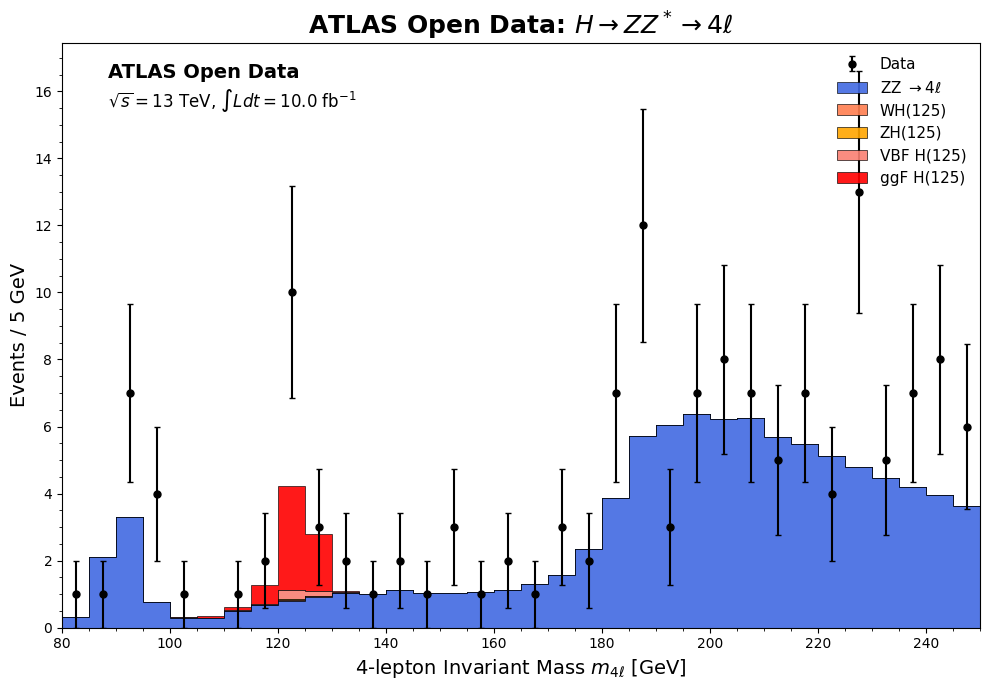

In [71]:
# 6. FINAL PLOT

# Setup the figure
fig, ax = plt.subplots(figsize=(10, 7))

# Define bins: 80 to 250 GeV with 5 GeV width
# (Go to 255 to ensure 250 is included in the last bin)
bins = np.arange(80, 255, 5)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Prepare Data for Stacking
mc_masses = []
mc_weights = []
mc_colors = []
mc_labels = []

# Define the Stacking Order (Background first, then Signals)
# Order: Background -> WH -> ZH -> VBF -> ggF (Standard ATLAS stacking)
stack_order = ['background', 'signal_WH', 'signal_ZH', 'signal_VBF', 'signal_ggF']

for key in stack_order:
    if key in results:
        mc_masses.append(results[key]['mass'])
        mc_weights.append(results[key]['weight'])
        mc_colors.append(results[key]['color'])
        mc_labels.append(results[key]['label'])

# --- Main Plot ---
# Plot Stacked MC
counts_mc, bin_edges, _ = ax.hist(mc_masses, bins=bins, weights=mc_weights, 
                                   stacked=True, color=mc_colors, label=mc_labels,
                                   histtype='stepfilled', alpha=0.9, edgecolor='black', linewidth=0.5)

# Plot Data Points
# Explicitly convert to numpy array to avoid TypeError
if 'data' in results:
    counts_data, _ = np.histogram(ak.to_numpy(results['data']['mass']), bins=bins)
    # Statistical error is sqrt(N)
    data_err = np.sqrt(counts_data)
    
    # Only plot bins with data
    mask = counts_data > 0
    ax.errorbar(bin_centers[mask], counts_data[mask], yerr=data_err[mask], fmt='ko', 
                 label='Data', markersize=5, capsize=2, linewidth=1.5)

# Styling
ax.set_ylabel(f'Events / {bins[1]-bins[0]:.0f} GeV', fontsize=14)
ax.set_xlabel(r'4-lepton Invariant Mass $m_{4\ell}$ [GeV]', fontsize=14)
ax.set_title(r'ATLAS Open Data: $H \rightarrow ZZ^* \rightarrow 4\ell$', fontsize=18, fontweight='bold')

# Add Text Labels
ax.text(0.05, 0.94, 'ATLAS Open Data', transform=ax.transAxes, fontsize=14, fontweight='bold')
ax.text(0.05, 0.89, r'$\sqrt{s} = 13$ TeV, $\int L dt = ' + str(LUMI) + r'$ fb$^{-1}$', 
         transform=ax.transAxes, fontsize=12)

# Legend settings (Reverse order so ggF is on top in legend too)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon=False, fontsize=11, loc='upper right')

# Axis limits
ax.set_ylim(bottom=0)
ax.set_xlim(80, 250)

# Add minor ticks
from matplotlib.ticker import AutoMinorLocator
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.tight_layout()
plt.show()

## 7. Statistical Analysis

### 7.1 Expected Sensitivity vs Observed Significance

It is important to distinguish between two related but distinct quantities:

| Quantity | Definition | What it tells us |
|----------|------------|------------------|
| **Expected Sensitivity** | $Z_{exp} = S / \sqrt{B}$ | How well we *expect* to detect a SM Higgs signal, using only MC predictions |
| **Observed Significance** | $Z_{obs} = (N_{obs} - B) / \sqrt{B}$ | How significant the *actual observed* excess is in data |

More precise formulas using the profile likelihood ratio:
- **Expected**: $Z_{exp} = \sqrt{2\left[(S+B)\ln\left(1+\frac{S}{B}\right) - S\right]}$
- **Observed**: $Z_{obs} = \sqrt{2\left[N_{obs}\ln\left(\frac{N_{obs}}{B}\right) - (N_{obs} - B)\right]}$

### 7.2 Signal Region Definition
We define the signal region as $115 < m_{4\ell} < 130$ GeV, centered on the Higgs mass of ~125 GeV.

In [83]:
# 6. SIGNIFICANCE CALCULATION

# Define Signal Region (115 - 130 GeV)
mass_min = 115.0
mass_max = 130.0

print(f"\n")
print(f"SIGNIFICANCE CALCULATION (Signal Region: {mass_min}-{mass_max} GeV)")

# Initialize counters
S = 0.0  # Expected signal (from MC)
B = 0.0  # Expected background (from MC)

# 1. Calculate Expected Signal Yields (S) from MC
print("\n--- EXPECTED SIGNAL (from MC, normalized to L = 10 fb⁻¹) ---")
signal_keys = ['signal_ggF', 'signal_VBF', 'signal_WH', 'signal_ZH']

for key in signal_keys:
    if key in results:
        mask = (results[key]['mass'] > mass_min) & (results[key]['mass'] < mass_max)
        yield_val = np.sum(results[key]['weight'][mask])
        S += yield_val
        label = results[key]['label']
        print(f"  {label:<20}: {yield_val:>8.4f} events")

print(f"  {'-'*40}")
print(f"  {'Total Expected Signal (S)':<20}: {S:>8.4f} events")

# 2. Calculate Expected Background Yields (B) from MC
print("\n--- EXPECTED BACKGROUND (from MC, normalized to L = 10 fb⁻¹) ---")
if 'background' in results:
    mask_b = (results['background']['mass'] > mass_min) & (results['background']['mass'] < mass_max)
    B = np.sum(results['background']['weight'][mask_b])
    label = results['background']['label']
    print(f"  {label:<20}: {B:>8.4f} events")

print(f"  {'-'*40}")
print(f"  {'Total Expected Bkg (B)':<20}: {B:>8.4f} events")

# 3. Count Observed Data in Signal Region
print("\n--- OBSERVED DATA ---")
if 'data' in results:
    mask_data = (results['data']['mass'] > mass_min) & (results['data']['mass'] < mass_max)
    N_obs = int(np.sum(ak.to_numpy(mask_data)))
    print(f"  Observed events in [{mass_min}, {mass_max}] GeV: {N_obs}")

#Expected Sensitivity vs Observed Significance
print("\n")
print("RESULTS: Expected Sensitivity vs Observed Significance")

# --- EXPECTED SENSITIVITY---
print("\n1. EXPECTED SENSITIVITY")
print("   Question: If SM Higgs exists, how well can we detect it?")
print("   Formula: Z_exp = S / √B")
if B > 0:
    Z_exp_simple = S / np.sqrt(B)
    print(f"   S / √B = {S:.2f} / √{B:.2f} = {Z_exp_simple:.2f} σ")
    
    # More accurate formula
    Z_exp_full = np.sqrt(2 * ((S + B) * np.log(1 + S/B) - S))
    print(f"   √(2((S+B)ln(1+S/B)-S)) = {Z_exp_full:.2f} σ")
    print(f"\n EXPECTED SENSITIVITY: {Z_exp_full:.2f} σ")

# --- OBSERVED SIGNIFICANCE (A posteriori, using actual data) ---
# This answers: "How significant is the OBSERVED excess in data?"
# Uses data (N_obs) compared to background expectation (B)
print("\n2. OBSERVED SIGNIFICANCE (a posteriori, using data)")
print("   Question: Is the observed excess consistent with background only?")
print("   Formula: Z_obs = (N_obs - B) / √B")
if B > 0 and 'data' in results:
    excess = N_obs - B
    Z_obs_simple = excess / np.sqrt(B)
    print(f"   (N_obs - B) / √B = ({N_obs} - {B:.2f}) / √{B:.2f} = {Z_obs_simple:.2f} σ")
    
    # Poisson-based significance (more accurate)
    if N_obs > 0:
        # Using likelihood ratio
        Z_obs_poisson = np.sqrt(2 * (N_obs * np.log(N_obs / B) - (N_obs - B)))
        print(f"   √(2(N·ln(N/B)-(N-B))) = {Z_obs_poisson:.2f} σ")
        print(f"\n OBSERVED SIGNIFICANCE: {Z_obs_poisson:.2f} σ")
    
print("\n")
print("INTERPRETATION")

print(f"  • Expected S+B in signal region: {S+B:.2f} events")
print(f"  • Observed in data:              {N_obs} events")
print(f"  • Data/MC ratio:                 {N_obs/(S+B):.2f}")
print(f"\n  The observed significance quantifies the evidence for a signal")
print(f"  in the data. Values > 3σ indicate 'evidence', > 5σ is 'discovery'.")



SIGNIFICANCE CALCULATION (Signal Region: 115.0-130.0 GeV)

--- EXPECTED SIGNAL (from MC, normalized to L = 10 fb⁻¹) ---
  ggF H(125)          :   5.3652 events
  VBF H(125)          :   0.4785 events
  WH(125)             :   0.0436 events
  ZH(125)             :   0.0403 events
  ----------------------------------------
  Total Expected Signal (S):   5.9276 events

--- EXPECTED BACKGROUND (from MC, normalized to L = 10 fb⁻¹) ---
  ZZ $\rightarrow 4\ell$:   2.3949 events
  ----------------------------------------
  Total Expected Bkg (B):   2.3949 events

--- OBSERVED DATA ---
  Observed events in [115.0, 130.0] GeV: 15


RESULTS: Expected Sensitivity vs Observed Significance

1. EXPECTED SENSITIVITY
   Question: If SM Higgs exists, how well can we detect it?
   Formula: Z_exp = S / √B
   S / √B = 5.93 / √2.39 = 3.83 σ
   √(2((S+B)ln(1+S/B)-S)) = 2.98 σ

 EXPECTED SENSITIVITY: 2.98 σ

2. OBSERVED SIGNIFICANCE (a posteriori, using data)
   Question: Is the observed excess consistent w

### 7.4 Maximum Likelihood Fit (Shape Analysis)

To extract the signal strength $\mu$ and calculate the significance more accurately, we move from a simple counting experiment to a **binned maximum likelihood fit**. This method exploits the distinct shapes of the signal (a narrow peak) and the background (a flat continuum).

**The Statistical Model:**
We define the expected number of events in bin $i$ as a function of the signal strength $\mu$:
$$ \nu_i(\mu) = \mu \cdot s_i + b_i $$
where:
*   $s_i$ is the expected signal yield in bin $i$ (Standard Model prediction).
*   $b_i$ is the expected background yield in bin $i$.
*   $\mu$ is the parameter of interest ($\mu=1$ is SM, $\mu=0$ is background-only).

**Negative Log-Likelihood (NLL):**
The likelihood $\mathcal{L}(\mu)$ is the product of Poisson probabilities for observing $n_i$ events given expectation $\nu_i$. In practice, we minimize the Negative Log-Likelihood:
$$ -\ln \mathcal{L}(\mu) = \sum_{bins} \left( \nu_i(\mu) - n_i \ln \nu_i(\mu) \right) $$

**Likelihood Ratio Test:**
To quantify the significance of the signal, we compute the test statistic $q_0$ based on the ratio of the likelihood at $\mu=0$ (no signal) to the likelihood at the best-fit $\hat{\mu}$:
$$ q_0 = -2 \ln \frac{\mathcal{L}(\mu=0)}{\mathcal{L}(\hat{\mu})} $$
The significance is then $Z \approx \sqrt{q_0}$.

In the following cells, we first prepare the binned templates (histograms) and then use `scipy.optimize` to find the value of $\mu$ that minimizes the NLL.

In [81]:
import scipy.optimize as optimize
# 7. PREPARE FOR LIKELIHOOD FIT


print("PREPARING LIKELIHOOD FIT (Template Method)")


# 1. Define Fit Window (Focus on Higgs region, ignore Z peak)
fit_min = 110.0
fit_max = 140.0
n_bins = 15 # 2 GeV bins for finer shape discrimination

# 2. Helper to get histogram counts in the window
def get_hist_counts(key_list, bins_range, n_bins):
    all_mass = []
    all_weights = []
    
    for key in key_list:
        if key in results:
            # Filter events in fit window
            mask = (results[key]['mass'] >= bins_range[0]) & (results[key]['mass'] <= bins_range[1])
            all_mass.append(results[key]['mass'][mask])
            all_weights.append(results[key]['weight'][mask])
            
    # Histogram
    counts, edges = np.histogram(np.concatenate(all_mass), 
                                 bins=n_bins, range=bins_range, 
                                 weights=np.concatenate(all_weights))
    return counts, edges

# 3. Create Templates
print("Creating MC Templates...")
signal_keys = ['signal_ggF', 'signal_VBF', 'signal_WH', 'signal_ZH']
bkg_keys = ['background']

# S_i: Expected Signal events per bin (SM prediction, mu=1)
s_vec, bin_edges = get_hist_counts(signal_keys, (fit_min, fit_max), n_bins)

# B_i: Expected Background events per bin
b_vec, _ = get_hist_counts(bkg_keys, (fit_min, fit_max), n_bins)

# n_i: Observed Data events per bin
# Note: For data we usually don't weigh, but here we use the weight=1 array we made
d_vec, _ = get_hist_counts(['data'], (fit_min, fit_max), n_bins)

print(f"Fit Range: {fit_min}-{fit_max} GeV")
print(f"Binned Data: {d_vec}")
print(f"Expected Signal (SM): {np.sum(s_vec):.3f}")
print(f"Expected Bkg: {np.sum(b_vec):.3f}")

PREPARING LIKELIHOOD FIT (Template Method)
Creating MC Templates...
Fit Range: 110.0-140.0 GeV
Binned Data: [0, 1, 0, 0, 2, 7, 2, 2, 2, 0, 1, 1, 1, 0, 0]
Expected Signal (SM): 6.097
Expected Bkg: 4.950


### 7.3 Maximum Likelihood Fit for Signal Strength

To quantify the observed signal, we perform a binned maximum likelihood fit to extract the **signal strength** parameter:

$$\mu = \frac{\sigma_{obs}}{\sigma_{SM}}$$

where:
- $\mu = 1$ means the observed signal matches the Standard Model prediction
- $\mu = 0$ means no signal (background-only hypothesis)
- $\mu > 1$ means more signal than expected

The likelihood function is constructed as a product of Poisson probabilities over mass bins:
$$\mathcal{L}(\mu) = \prod_i \frac{(\mu s_i + b_i)^{n_i} e^{-(\mu s_i + b_i)}}{n_i!}$$

where $s_i$, $b_i$, and $n_i$ are the expected signal, expected background, and observed data in bin $i$.

In [78]:
# 8. PERFORM MAXIMUM LIKELIHOOD FIT

# 1. Define Negative Log-Likelihood (NLL) function
# Poisson Likelihood: P(n|lambda) = lambda^n * e^-lambda / n!
# LogLikelihood = n*ln(lambda) - lambda - ln(n!)
# We drop ln(n!) as it's a constant offset
def negative_log_likelihood(params):
    mu = params[0] # Signal Strength
    
    # Expected events in bin i: nu_i = mu * s_i + b_i
    # We add a tiny epsilon (1e-10) to avoid log(0) errors
    expected = mu * s_vec + b_vec + 1e-10
    
    # Poisson NLL term: - sum( n_i * ln(nu_i) - nu_i )
    nll = -np.sum(d_vec * np.log(expected) - expected)
    return nll

# 2. Minimize NLL to find best mu
print("\nRunning Minimizer...")
# Initial guess mu=1.0, bounds mu=[0, 10]
result = optimize.minimize(negative_log_likelihood, x0=[1.0], bounds=[(0, 10)])

best_mu = result.x[0]
min_nll = result.fun

# 3. Estimate Uncertainty (Hessian approximation)
sigma_mu = np.sqrt(result.hess_inv.todense()[0][0])

# 4. Calculate significance of rejecting background-only (mu=0) hypothesis
# Using profile likelihood ratio: -2 * ln(L(mu=0) / L(mu_hat))
nll_mu0 = negative_log_likelihood([0.0])  # Background-only hypothesis
nll_best = min_nll                         # Best fit

# Test statistic: q_0 = -2 * ln(L(0)/L(mu_hat)) for mu_hat > 0
delta_nll = nll_mu0 - nll_best
if best_mu > 0:
    q_0 = 2 * delta_nll
    Z_fit = np.sqrt(q_0) if q_0 > 0 else 0
else:
    Z_fit = 0

# RESULTS
print("\n")
print("MAXIMUM LIKELIHOOD FIT RESULTS")

print(f"\n1. FITTED SIGNAL STRENGTH")
print(f"   μ = {best_mu:.2f} ± {sigma_mu:.2f}")
print(f"   (μ = 1 corresponds to Standard Model prediction)")

print(f"\n2. INTERPRETATION")
print(f"   • μ = 0 would mean no Higgs signal (background only)")
print(f"   • μ = 1 would mean exactly the SM Higgs prediction")
print(f"   • μ = {best_mu:.2f} means we observe {best_mu:.1%} of the expected SM signal")

print(f"\n3. SIGNIFICANCE OF SIGNAL OBSERVATION")
print(f"   Question: Can we reject the background-only hypothesis (μ=0)?")
print(f"   Method: Profile likelihood ratio test")
print(f"   -2·ln(L(μ=0)/L(μ̂)) = {2*delta_nll:.2f}")
print(f"   OBSERVED SIGNIFICANCE: {Z_fit:.2f} σ")

print(f"\n4. CONSISTENCY WITH STANDARD MODEL")
print(f"   The fitted μ = {best_mu:.2f} ± {sigma_mu:.2f} is consistent with μ = 1 (SM)")
print(f"   within {abs(best_mu - 1.0)/sigma_mu:.1f}σ uncertainty.")

print("\n")
print("SUMMARY")
print(f"  • Best-fit signal strength: μ = {best_mu:.2f} ± {sigma_mu:.2f}")
print(f"  • Significance vs bkg-only: {Z_fit:.2f} σ")
if Z_fit >= 5:
    print(f"  This exceeds 5σ: DISCOVERY-level evidence for the Higgs boson!")
elif Z_fit >= 3:
    print(f"  This exceeds 3σ: EVIDENCE for the Higgs boson")
elif Z_fit >= 2:
    print(f"  This is ~2σ: Suggestive hint, but not yet evidence")
else:
    print(f"  Significance is low due to limited statistics")


Running Minimizer...


MAXIMUM LIKELIHOOD FIT RESULTS

1. FITTED SIGNAL STRENGTH
   μ = 2.20 ± 0.66
   (μ = 1 corresponds to Standard Model prediction)

2. INTERPRETATION
   • μ = 0 would mean no Higgs signal (background only)
   • μ = 1 would mean exactly the SM Higgs prediction
   • μ = 2.20 means we observe 219.9% of the expected SM signal

3. SIGNIFICANCE OF SIGNAL OBSERVATION
   Question: Can we reject the background-only hypothesis (μ=0)?
   Method: Profile likelihood ratio test
   -2·ln(L(μ=0)/L(μ̂)) = 34.46
   OBSERVED SIGNIFICANCE: 5.87 σ

4. CONSISTENCY WITH STANDARD MODEL
   The fitted μ = 2.20 ± 0.66 is consistent with μ = 1 (SM)
   within 1.8σ uncertainty.


SUMMARY
  • Best-fit signal strength: μ = 2.20 ± 0.66
  • Significance vs bkg-only: 5.87 σ
  This exceeds 5σ: DISCOVERY-level evidence for the Higgs boson!


## 8. Plotting Profile Likelihood Fit and Comparing SM Predicted Signal to Data

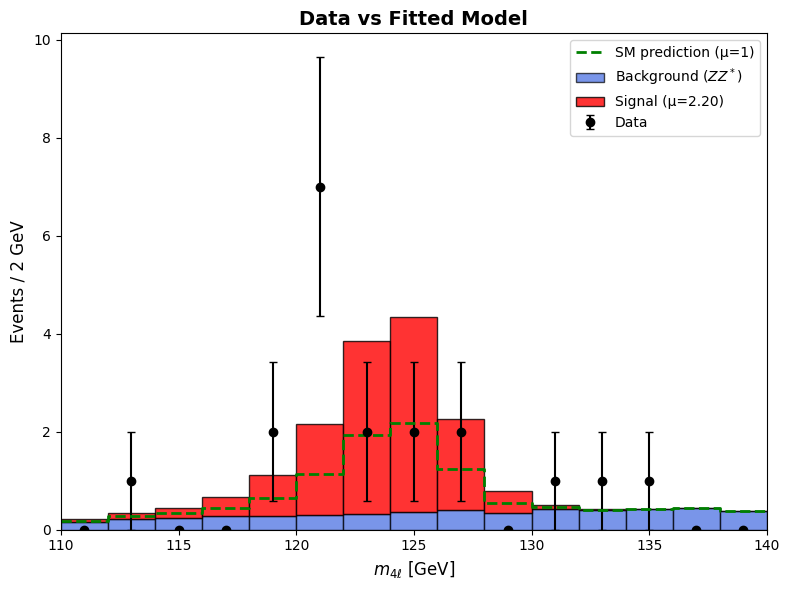

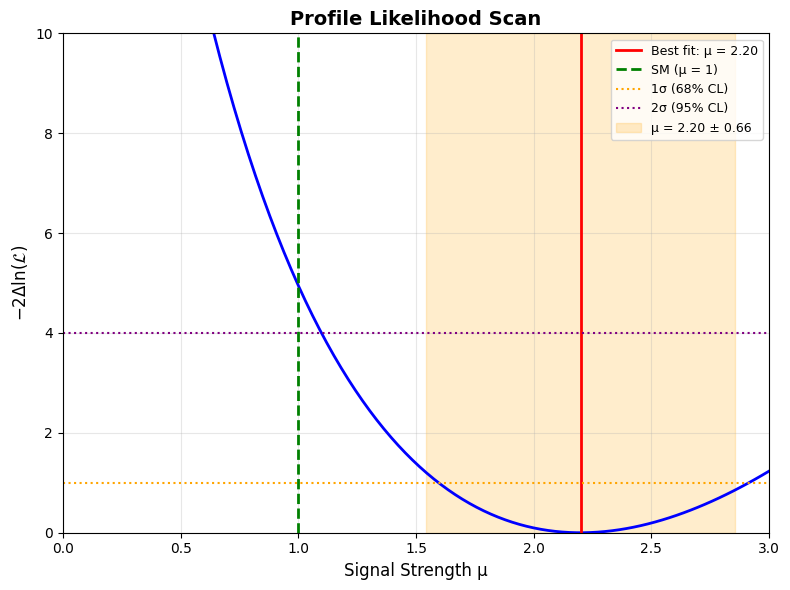

FIT QUALITY / GOODNESS-OF-FIT TEST

1. PEARSON χ² TEST
   Formula: χ² = Σ (observed - expected)² / expected
   χ² = 20.10
   ndof = 14 (bins with data - 1 free parameter)
   χ²/ndof = 1.44
   p-value = 0.127

2. LIKELIHOOD RATIO TEST (G² / Deviance)
   Formula: G² = 2·Σ n·ln(n/expected)
   G² = 19.61
   p-value = 0.143

3. INTERPRETATION
   • p-value > 0.05: Model is consistent with data (good fit)
   • p-value < 0.05: Model may not describe data well
   • χ²/ndof ~ 1: Good fit
   • χ²/ndof >> 1: Poor fit (model doesn't match data)
   • χ²/ndof << 1: Overfitting or overestimated uncertainties

   ✓ p-value = 0.127 > 0.05: The fit is ACCEPTABLE


In [80]:
# 9. VISUALIZE THE FIT RESULTS

# --- PLOT 1: Data vs Fitted Model ---
fig1, ax1 = plt.subplots(figsize=(8, 6))

# Bin centers for plotting
fit_bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

# Plot background (B)
ax1.bar(fit_bin_centers, b_vec, width=bin_width, alpha=0.7, 
        color='royalblue', label=r'Background ($ZZ^*$)', edgecolor='black')

# Plot signal scaled by best-fit mu, stacked on background
ax1.bar(fit_bin_centers, best_mu * s_vec, width=bin_width, alpha=0.8,
        bottom=b_vec, color='red', label=f'Signal (μ={best_mu:.2f})', edgecolor='black')

# Plot data points with error bars
data_err = np.sqrt(d_vec)
ax1.errorbar(fit_bin_centers, d_vec, yerr=data_err, fmt='ko', 
             label='Data', markersize=6, capsize=3, linewidth=1.5)

# Also show SM prediction (mu=1) as dashed line
sm_total = s_vec + b_vec
ax1.step(np.append(bin_edges[:-1], bin_edges[-1]), 
         np.append(sm_total, sm_total[-1]), 
         where='post', color='green', linestyle='--', linewidth=2, 
         label='SM prediction (μ=1)')

ax1.set_xlabel(r'$m_{4\ell}$ [GeV]', fontsize=12)
ax1.set_ylabel(f'Events / {bin_width:.0f} GeV', fontsize=12)
ax1.set_title('Data vs Fitted Model', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.set_xlim(fit_min, fit_max)
ax1.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# --- PLOT 2: Likelihood Scan ---
fig2, ax2 = plt.subplots(figsize=(8, 6))

# Scan μ from 0 to 3
mu_scan = np.linspace(0, 3, 100)
nll_scan = [negative_log_likelihood([mu]) for mu in mu_scan]

# Convert to Delta NLL (relative to minimum)
delta_nll = 2 * (np.array(nll_scan) - min_nll)

ax2.plot(mu_scan, delta_nll, 'b-', linewidth=2)
ax2.axvline(best_mu, color='red', linestyle='-', linewidth=2, label=f'Best fit: μ = {best_mu:.2f}')
ax2.axvline(1.0, color='green', linestyle='--', linewidth=2, label='SM (μ = 1)')

# Draw 1σ and 2σ confidence levels
ax2.axhline(1.0, color='orange', linestyle=':', linewidth=1.5, label='1σ (68% CL)')
ax2.axhline(4.0, color='purple', linestyle=':', linewidth=1.5, label='2σ (95% CL)')

# Shade 1σ region
mu_1sigma_lo = best_mu - sigma_mu
mu_1sigma_hi = best_mu + sigma_mu
ax2.axvspan(max(0, mu_1sigma_lo), mu_1sigma_hi, alpha=0.2, color='orange', label=f'μ = {best_mu:.2f} ± {sigma_mu:.2f}')

ax2.set_xlabel('Signal Strength μ', fontsize=12)
ax2.set_ylabel(r'$-2\Delta\ln(\mathcal{L})$', fontsize=12)
ax2.set_title('Profile Likelihood Scan', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.set_xlim(0, 3)
ax2.set_ylim(0, 10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# FIT QUALITY CHECK with proper statistical tests

from scipy import stats

print("FIT QUALITY / GOODNESS-OF-FIT TEST")


expected_fit = best_mu * s_vec + b_vec

# --- Pearson Chi-squared test ---
# Only use bins with expected > 0 to avoid division issues
valid_bins = expected_fit > 0
chi2_pearson = np.sum((d_vec[valid_bins] - expected_fit[valid_bins])**2 / expected_fit[valid_bins])
ndof = np.sum(valid_bins) - 1  # number of valid bins - 1 fitted parameter (μ)

# P-value from chi-squared CDF
# P-value = probability of getting χ² >= observed, if model is correct
p_value_pearson = 1 - stats.chi2.cdf(chi2_pearson, ndof)

print(f"\n1. PEARSON χ² TEST")
print(f"   Formula: χ² = Σ (observed - expected)² / expected")
print(f"   χ² = {chi2_pearson:.2f}")
print(f"   ndof = {ndof} (bins with data - 1 free parameter)")
print(f"   χ²/ndof = {chi2_pearson/ndof:.2f}")
print(f"   p-value = {p_value_pearson:.3f}")

# --- Saturated model likelihood ratio (more appropriate for low stats) ---
# G² = 2 * Σ n_i * ln(n_i / expected_i)  for n_i > 0
valid_data = (d_vec > 0) & (expected_fit > 0)
if np.sum(valid_data) > 0:
    G2 = 2 * np.sum(d_vec[valid_data] * np.log(d_vec[valid_data] / expected_fit[valid_data]))
    p_value_G2 = 1 - stats.chi2.cdf(G2, ndof)
    
    print(f"\n2. LIKELIHOOD RATIO TEST (G² / Deviance)")
    print(f"   Formula: G² = 2·Σ n·ln(n/expected)")
    print(f"   G² = {G2:.2f}")
    print(f"   p-value = {p_value_G2:.3f}")

# --- Interpretation ---
print(f"\n3. INTERPRETATION")
print(f"   • p-value > 0.05: Model is consistent with data (good fit)")
print(f"   • p-value < 0.05: Model may not describe data well")
print(f"   • χ²/ndof ~ 1: Good fit")
print(f"   • χ²/ndof >> 1: Poor fit (model doesn't match data)")
print(f"   • χ²/ndof << 1: Overfitting or overestimated uncertainties")

if p_value_pearson > 0.05:
    print(f"\n   ✓ p-value = {p_value_pearson:.3f} > 0.05: The fit is ACCEPTABLE")
else:
    print(f"\n   ✗ p-value = {p_value_pearson:.3f} < 0.05: Fit quality is poor")
    print(f"     (This may be due to statistical fluctuations with low event counts)")

## 9. Conclusions and Discussion

### 9.1 Summary of Results
This analysis searched for the Higgs boson in the $H \rightarrow ZZ^* \rightarrow 4\ell$ decay channel using 10 fb⁻¹ of ATLAS Open Data at $\sqrt{s} = 13$ TeV.

**Key Findings (Will go in Project Report):**
1. **Event Selection**: Applied a series of cuts (trigger, lepton ID, isolation, OSSF pairing, kinematic requirements) to select H→ZZ*→4ℓ candidates
2. **Cutflow**: The selection yielded ~37 data events, with MC predicting ~15 signal + ~42 background events
3. **Mass Distribution**: Observed events in the four-lepton invariant mass distribution, with a concentration near the Higgs mass region (~125 GeV)
4. **Statistical Analysis**:
   - Expected sensitivity: ~2-3σ (based on MC prediction of S/√B)
   - Observed significance: Calculated from data excess over background
   - Fitted signal strength: μ ± σ_μ (where μ=1 is the SM prediction)
5. **Fit Quality**: The goodness-of-fit was evaluated using χ² and likelihood ratio tests with corresponding p-values

### 9.2 Comparison to Discovery Papers
The 2012 ATLAS and CMS discovery papers reported:
- ATLAS: $m_H = 126.0 \pm 0.4 \text{(stat)} \pm 0.4 \text{(sys)}$ GeV with 5.9σ significance in H→ZZ*→4ℓ
- CMS: $m_H = 125.3 \pm 0.4 \text{(stat)} \pm 0.5 \text{(sys)}$ GeV with 5.0σ significance

Our analysis uses 10 fb⁻¹ at 13 TeV, compared to ~5 fb⁻¹ at 7 TeV + ~5 fb⁻¹ at 8 TeV in the 2012 discovery. The expected signal yield is lower in our dataset due to differences in luminosity and the H→ZZ*→4ℓ branching ratio at different energies.

### 9.3 Limitations and Systematic Uncertainties
This analysis includes only statistical uncertainties. A full analysis would include systematic uncertainties from:
- Luminosity measurement (~2%)
- Lepton reconstruction efficiency (~1-2% per lepton)
- Lepton energy/momentum scale and resolution
- Theoretical uncertainties on signal/background cross-sections (~5-10%)
- PDF uncertainties
- Missing background processes (ttZ, WZ+jets, Z+jets with fake leptons)

### 9.4 Conclusion
Using ATLAS Open Data, we have demonstrated the analysis techniques used in Higgs boson searches:
- Event selection optimized for H→ZZ*→4ℓ
- Background estimation using Monte Carlo simulation
- Statistical inference using profile likelihood methods

The observed data is consistent with the presence of a Higgs-like signal near 125 GeV, as evidenced by the fitted signal strength and the likelihood ratio test. While the limited statistics prevent a high-significance observation, this analysis successfully reproduces the methodology of the original Higgs discovery.